In [22]:
"""import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from numpy.random import RandomState
from sklearn.model_selection import RandomizedSearchCV
"""
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import csv
from sklearn.metrics import r2_score
from datetime import datetime
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy import stats
from category_encoders import CatBoostEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import uniform 
from numpy.random import RandomState
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor 
from mlxtend.frequent_patterns import apriori

ModuleNotFoundError: No module named 'mlxtend'

In [2]:
#read data
df_movies = pd.read_csv('../../Dataset/ml-25m/movies.csv')
df_ratings = pd.read_csv('../../Dataset/ml-25m/ratings.csv')

In [3]:
# df_movies year is extracted from the df_movies title
df_movies["movie_year"] = df_movies["title"].str.slice(start=-7,stop=-1)
df_movies["movie_year"] = df_movies.movie_year.str.extract('(\d+)')
df_movies["movie_year"] = pd.to_numeric(df_movies["movie_year"])
#step-by-step describe içindeki min movie_year değeri absürt olanları düşürdük 201'de son buldu
df_movies = df_movies.loc[(df_movies['movie_year'] > 201)].copy()

In [4]:
df_movies.describe()

,movieId,movie_year
count,62012.000000,62012.000000
mean,121895.213749,1992.045265
std,63321.033223,25.364698
min,1.000000,1874.000000
25%,81696.000000,1976.000000
50%,137613.000000,2002.000000
75%,173009.500000,2012.000000
max,209171.000000,2019.000000


In [5]:
#timestamp kolonu düşürüldü
df_ratings.drop(columns='timestamp', axis=1, inplace=True)
#boş satırlar düşürüldü
df_movies = df_movies.copy().dropna()
#genrelar ayırılarak yeni bir df oluşturuldu
genres = df_movies['genres'].str.get_dummies('|')
#ayırılmış genreler ve filmler birleştirilip 'genres' satırı düşürüldü
df_movies = pd.concat([df_movies,genres], axis=1)
df_movies.drop(columns='genres', axis=1, inplace=True)

In [6]:
#genre plotlama
genres_count = df_movies.sum(axis = 0, skipna = True)
genres_count = genres_count.to_frame()
genres_count = genres_count.drop(genres_count.index[range(3)])
genres_count.columns =['Count']
genres_count.reset_index(inplace=True)
genres_count.rename(columns={"index": "Genre"},inplace = True)
genres_count

,Genre,Count
0,(no genres listed),4798
1,Action,7335
2,Adventure,4136
3,Animation,2927
4,Children,2930
5,Comedy,16843
6,Crime,5314
7,Documentary,5561
8,Drama,25559
9,Fantasy,2724


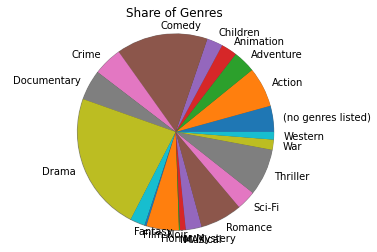

In [7]:
plt.pie(genres_count["Count"], labels = genres_count["Genre"],shadow=True,radius = 10, center = (5,5))
plt.title("Share of Genres")
plt.axis('equal')
plt.show()

In [8]:
#iki df'i birleştirmek
merged_df = pd.merge(df_movies, df_ratings)
merged_df

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2,3.5
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,3,4.0
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,4,3.0
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,5,4.0
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,8,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24988344,209157,We (2018),2018.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,119571,1.5
24988345,209159,Window of the Soul (2001),2001.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,115835,3.0
24988346,209163,Bad Poems (2018),2018.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,6964,4.5
24988347,209169,A Girl Thing (2001),2001.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,119571,3.0


In [9]:
df_for_lightgbm = merged_df.copy()
df_for_lightgbm.head(5)

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2,3.5
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,3,4.0
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,4,3.0
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,5,4.0
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,8,4.0


In [10]:
#title, '(no genres listed)', 'userId' featureları çıkartıldı?!?!
df_for_lightgbm = df_for_lightgbm[df_for_lightgbm.columns.difference(['title', '(no genres listed)', 'userId'])].copy()
column_names = df_for_lightgbm.columns


In [11]:
#normalize edildi
df_for_lightgbm_normalized = preprocessing.normalize(df_for_lightgbm)
df_for_lightgbm_normalized = pd.DataFrame(df_for_lightgbm_normalized,columns = column_names)

In [12]:
df_for_lightgbm_normalized.head(5)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId,movie_year,rating
0,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999998,0.001754
1,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999997,0.002005
2,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999998,0.001504
3,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999997,0.002005
4,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999997,0.002005


In [13]:
X = df_for_lightgbm_normalized[df_for_lightgbm_normalized.columns.difference(['rating'])]
y = df_for_lightgbm_normalized['rating']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=31)

In [20]:
randomstate = RandomState(31)

# lgbm_optimization_parameters
max_depth = randomstate.randint(2,15, size=4)
num_leaves = [2, 4, 8, 16]
n_estimators = randomstate.randint(100,1000, size=4)
learning_rate = [0.1, 0.2, 0.4]

lgbm_optimization_parameters = {    
    'n_estimators' : n_estimators,
    'max_depth': max_depth,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,}

# lgbm_searcher 
lgbm = LGBMRegressor(random_state = 31)
lgbm_searcher = RandomizedSearchCV(estimator = lgbm, 
                                  param_distributions = lgbm_optimization_parameters,
                                  n_iter = 5,
                                  random_state = 31)

#lgbm_search 
lgbm_search = lgbm_searcher.fit(X_train, y_train)

# Obtaining the best model from random search
lgbm_regressor = lgbm_search.best_estimator_ 
lgbm_search.best_params_ 

{'num_leaves': 8, 'n_estimators': 926, 'max_depth': 4, 'learning_rate': 0.2}

In [23]:
y_pred_lgbm = lgbm_regressor.predict(X_validation)
R_square_lgbm = r2_score(y_validation, y_pred_lgbm) 
print(R_square_lgbm)

0.8832236358066822


In [38]:
import joblib
# save model
joblib.dump(lgbm_search, 'lgb.pkl')
# load model
gbm_pickle = joblib.load('lgb.pkl')

In [40]:
y_pred_lgbm = gbm_pickle.predict(X_validation)
R_square_lgbm = r2_score(y_validation, y_pred_lgbm) 
print(R_square_lgbm)

0.8832236358066822
